In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# Load Data

In [2]:
data = pd.read_csv('ypred.csv')

In [3]:
data.head(5)

,Country Code,Txn Code,Qtr,Year,Date,Volume
0,1,1,1,2017,1,6051
1,2,2,2,2017,2,12102
2,3,3,3,2017,3,18153
3,4,4,4,2017,4,24204
4,5,5,1,2017,5,22187


# Preprocessing

In [4]:
data = pd.get_dummies(data, columns=['Year'])

In [5]:
data.head()

,Country Code,Txn Code,Qtr,Date,Volume,Year_2017,Year_2018
0,1,1,1,1,6051,1,0
1,2,2,2,2,12102,1,0
2,3,3,3,3,18153,1,0
3,4,4,4,4,24204,1,0
4,5,5,1,5,22187,1,0


In [6]:
data['Country Code'] = (data['Country Code']-data['Country Code'].min()) / (data['Country Code'].max()-
                                                                            data['Country Code'].min())
data['Txn Code'] = (data['Txn Code']-data['Txn Code'].min()) / (data['Txn Code'].max()-data['Txn Code'].min())
data['Qtr'] = (data['Qtr']-data['Qtr'].min()) / (data['Qtr'].max()-data['Qtr'].min())
data['Date'] = (data['Date']-data['Date'].min()) / (data['Date'].max()-data['Date'].min())

In [7]:
data.head()

,Country Code,Txn Code,Qtr,Date,Volume,Year_2017,Year_2018
0,0.00,0.00,0.000000,0.000000,6051,1,0
1,0.25,0.25,0.333333,0.034483,12102,1,0
2,0.50,0.50,0.666667,0.068966,18153,1,0
3,0.75,0.75,1.000000,0.103448,24204,1,0
4,1.00,1.00,0.000000,0.137931,22187,1,0


In [8]:
data['log_Volume'] = np.log(data['Volume'])

In [9]:
data = data.sample(n=len(data), random_state=42)

In [10]:
data.head()

,Country Code,Txn Code,Qtr,Date,Volume,Year_2017,Year_2018,log_Volume
521,0.25,0.25,0.666667,0.379310,14126,0,1,9.555772
941,0.25,0.25,0.000000,0.379310,10090,0,1,9.219300
741,0.25,0.25,1.000000,0.724138,16144,0,1,9.689304
980,0.00,0.00,1.000000,0.689655,12108,0,1,9.401622
411,0.25,0.25,0.000000,0.724138,10085,1,0,9.218804


# Train test split

In [11]:
X_train = data[['Country Code', 'Txn Code', 'Qtr', 'Date', 'Year_2017', 'Year_2018']].to_numpy()

In [12]:
y_train = data['log_Volume'].to_numpy()

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model

In [14]:
from MLP import MLP

In [15]:
def err(y_tr, y_pr):
    return (y_tr - y_pr) ** 2

In [16]:
net = MLP(6, 2, [10, 10])

lr = 0.01
N_train = len(y_train)
N_val = len(y_val)

train_epochs_loss = []
val_epochs_loss = []
for E in range(50):
    mean_err_train = []
    mean_err_val = []
    for obs, y_true in zip(X_train, y_train):
        y_pred, gh = net.forward(obs, mode='train')
        net.backprop(y_true, y_pred, gradient=gh['gradient'], hidden_states=gh['hidden_states'], lr=lr)
    
    for obs, y_true in zip(X_train, y_train):
        y_pred = net.forward(obs, mode='eval')
        mean_err_train.append(err(y_true, y_pred) / N_train)
        
    for obs, y_true in zip(X_val, y_val):
        y_pred = net.forward(obs, mode='eval')
        mean_err_val.append(err(y_true, y_pred) / N_val)
    if E % 1 == 0:
        print(f"EPOCH {E+1}, train loss = {np.sum(mean_err_train):.5}, val loss = {np.sum(mean_err_val):.5}")
    train_epochs_loss.append(np.sum(mean_err_train))
    val_epochs_loss.append(np.sum(mean_err_val))

EPOCH 1, train loss = 0.10898, val loss = 0.11032
EPOCH 2, train loss = 0.099941, val loss = 0.1013
EPOCH 3, train loss = 0.089379, val loss = 0.090828
EPOCH 4, train loss = 0.077485, val loss = 0.079082
EPOCH 5, train loss = 0.064762, val loss = 0.066543
EPOCH 6, train loss = 0.051983, val loss = 0.053934
EPOCH 7, train loss = 0.040026, val loss = 0.042085
EPOCH 8, train loss = 0.029669, val loss = 0.031745
EPOCH 9, train loss = 0.021392, val loss = 0.023395
EPOCH 10, train loss = 0.015273, val loss = 0.01713
EPOCH 11, train loss = 0.011016, val loss = 0.012685
EPOCH 12, train loss = 0.0081418, val loss = 0.0096069
EPOCH 13, train loss = 0.0061894, val loss = 0.0074545
EPOCH 14, train loss = 0.0048231, val loss = 0.0059047
EPOCH 15, train loss = 0.0038323, val loss = 0.0047524
EPOCH 16, train loss = 0.0030927, val loss = 0.003874
EPOCH 17, train loss = 0.0025293, val loss = 0.0031934
EPOCH 18, train loss = 0.0020948, val loss = 0.0026605
EPOCH 19, train loss = 0.0017569, val loss = 0.

# Loss curve

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

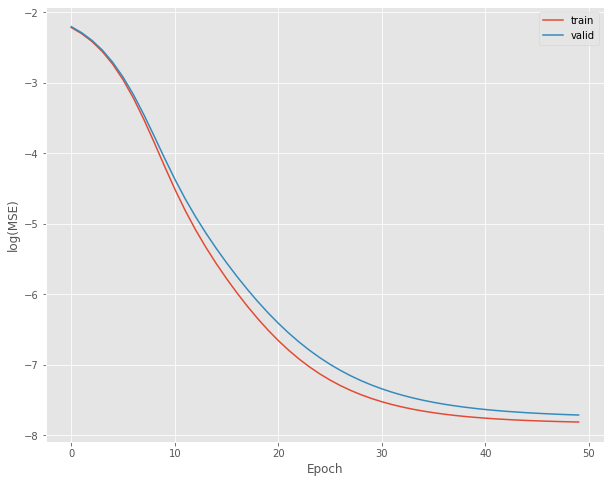

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(np.log(train_epochs_loss))
plt.plot(np.log(val_epochs_loss))
plt.legend(['train', 'valid'])
plt.ylabel('log(MSE)')
plt.xlabel('Epoch')
plt.show()

In [19]:
for obs, y_true in zip(X_val[:50], y_val[:50]):
    y_pred = net.forward(obs, mode='eval')
    print(f'real - {round(np.exp(y_true))}', f'pred - {np.exp(y_pred):.2f}')

real - 16144 pred - 16237.58
real - 12108 pred - 12068.82
real - 12108 pred - 12025.58
real - 16144 pred - 16445.43
real - 10090 pred - 9797.03
real - 12108 pred - 11895.46
real - 16144 pred - 16445.43
real - 12102 pred - 11902.41
real - 18153 pred - 18516.00
real - 6051 pred - 6330.70
real - 20180 pred - 20388.19
real - 24216 pred - 24307.47
real - 20180 pred - 20664.00
real - 20170 pred - 20750.60
real - 22187 pred - 22563.67
real - 14126 pred - 13913.93
real - 22198 pred - 22477.94
real - 20170 pred - 20729.00
real - 22187 pred - 22082.01
real - 16136 pred - 16274.74
real - 14119 pred - 14157.10
real - 16136 pred - 16419.96
real - 10090 pred - 9809.62
real - 24204 pred - 24379.61
real - 8068 pred - 8018.76
real - 16136 pred - 16460.40
real - 10085 pred - 9728.83
real - 24204 pred - 24434.76
real - 26221 pred - 25892.16
real - 22187 pred - 22579.43
real - 18162 pred - 18504.43
real - 14119 pred - 13922.37
real - 16136 pred - 16275.51
real - 22198 pred - 22474.27
real - 24204 pred - 2

In [20]:
net.get_layers()

hidden layer 1
[[ 0.6286064   1.09012007  0.99499228  0.6952444   0.27759528  0.4200568
   0.48847845  1.10627878  0.69146272  1.00449386]
 [ 0.27465078  1.10931562  1.09544098  0.30892502  0.3034016   0.44746679
   0.73463708  0.76485906  0.52229273  0.58765042]
 [ 0.77714099  0.27965573  0.59688117  0.34040402  0.43455912  0.94690933
   0.58718684  0.82715389  0.6447661   0.33701971]
 [ 0.37767981 -0.16568662 -0.30354027  0.8091446   0.86034138  0.48574702
   0.08854557 -0.22713517  0.51444162  0.17725046]
 [-0.16731993  0.09478764 -0.42832214  0.79460339  0.18950274  0.26330749
  -0.01222123  0.04253041  0.34739554 -0.1609249 ]
 [ 0.58471161  0.21829008  0.20867862  0.72270333  0.49008445  0.38514427
  -0.39730771 -0.45099358 -0.2460114  -0.20474167]]
hidden layer 2
[[ 0.03971051 -0.05112851  0.55749732  0.05639506  0.18909786  0.19853381
  -0.03846885  0.63061172 -0.13839607  0.60378933]
 [ 0.47204151  0.04767322 -0.15751605  0.63289747  0.62908105  0.57844445
   0.61726817 -0.0708